# In this version, I am going to directly fit to the spike train data


### from the last version

* k_high = 8
* C = 500


### optimizing a,d b, k_low in the following order


* a: .00001 to .001 **and** d: 1 to 6
* b: 1 to 5 **and** k_low: .001 to .1


In [1]:
import ipyparallel
from tempfile import TemporaryFile
data = TemporaryFile()    

In [2]:
clients = ipyparallel.Client('/home/snara025/.ipython/profile_myprofile/security/ipcontroller-client.json')#, url_file='/home/snara025/.ipython/profile_myprofile/security/ipcontroller-client.json', sshserver='192.168.233.126',
clients.ids

lview = clients.load_balanced_view() 
dview = clients[:]

In [3]:
%%px --local 
from brian2 import * 
#import brian2 as bn
import numpy as np
import pylab
import itertools
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from __future__ import division
%matplotlib inline






CompositeError: one or more exceptions from call to method: execute
[0:execute]: ImportError: No module named brian2
[1:execute]: ImportError: No module named brian2
[2:execute]: ImportError: No module named brian2
[3:execute]: ImportError: No module named brian2
.... 16 more exceptions ...

In [4]:
clients.ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59]


## Setting initial values constant

* Setting Vpeak, c, V_r, V_t, C from actual data
* I am getting these from a paper and neuroelectro
* Also using a steady-state I-f curve from the same data


In [5]:
%%px --local

# this is the I-f data for EC3 pyramidal neuron
s = pd.read_csv('EC3_I_f.csv',header = None)
EC3_I_f_data = s.as_matrix(columns=[1])

s1 = pd.read_csv('EC3_spikes.csv',header = None)
EC3_spike_times = s1.as_matrix(columns=[0])
print EC3_spike_times


[[  16.7072893 ]
 [  37.81700416]
 [  61.74359666]
 [  92.72081706]
 [ 125.10647629]
 [ 160.24997681]
 [ 188.41875332]
 [ 223.63815773]
 [ 257.44068954]
 [ 294.05166525]
 [ 332.02891095]
 [ 370.02302418]
 [ 403.83398976]
 [ 439.0449604 ]
 [ 475.67280364]
 [ 513.69221816]
 [ 551.72006646]
 [ 592.53105734]
 [ 636.2010947 ]
 [ 678.42895818]
 [ 716.49054153]
 [ 754.53525736]
 [ 796.75468707]
 [ 843.25003584]
 [ 882.6778892 ]
 [ 929.16480421]
 [ 974.22641287]]
[stdout:0] 
[[  16.7072893 ]
 [  37.81700416]
 [  61.74359666]
 [  92.72081706]
 [ 125.10647629]
 [ 160.24997681]
 [ 188.41875332]
 [ 223.63815773]
 [ 257.44068954]
 [ 294.05166525]
 [ 332.02891095]
 [ 370.02302418]
 [ 403.83398976]
 [ 439.0449604 ]
 [ 475.67280364]
 [ 513.69221816]
 [ 551.72006646]
 [ 592.53105734]
 [ 636.2010947 ]
 [ 678.42895818]
 [ 716.49054153]
 [ 754.53525736]
 [ 796.75468707]
 [ 843.25003584]
 [ 882.6778892 ]
 [ 929.16480421]
 [ 974.22641287]]
[stdout:1] 
[[  16.7072893 ]
 [  37.81700416]
 [  61.74359666]
 [  9

In [6]:
%%px --local
k_high = 8
C = 550



real_spike_train  = np.zeros(1000)
real_spike_train.fill(-70.9 *mV)

EC3_spike_times = EC3_spike_times.astype(int)
spike_list = np.arange(0,len(EC3_spike_times), 1)
for i in spike_list:
    real_spike_train[(EC3_spike_times[i])] = 8 *mV

# k_high has been computed!



## Step 0: Check what we get with previously determined C and k. Holding other stuff constant

In [7]:
EC3_input = np.arange(0,410, 10) 
EC3_input = np.broadcast_to(EC3_input, (1000,41))
EC3_input = TimedArray(EC3_input*pamp, dt=1*ms )

# EC3 pyramidal neuron parameters.  
EC3_a = .00001/ms
EC3_b = 5 * nsiemens
EC3_c = -74.153 *mV
EC3_d = 5 *pA #I think I shoudl use pico amps for this.. seriously 
EC3_v_peak = 7.7 * mV # this is v_peak. There is no such thing as a firing threshold. 
EC3_v_r = -70.9 # mV
EC3_v_t = -56.9 # mV 
EC3_C = C * pF
EC3_k_low = .097 * nsiemens/mV
EC3_k_high = k_high * nsiemens/mV

#the quadratic terms based on v_r and v_t
EC3_v_a = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
EC3_v_b = -1*(EC3_v_r + EC3_v_t) /ms#/ms
EC3_v_c = (EC3_v_r * EC3_v_t) *(mV/ms)#*mV/ms 
# Standard Izhikevich neuron equations.  
EC3_p_eqs = '''
dv/dt = ((k*(mV/nS)*(EC3_v_a*(v**2) + EC3_v_b*(v) + EC3_v_c))*pF/EC3_C - u/EC3_C + I/EC3_C ) : volt
du/dt = EC3_a*((EC3_b*(v - EC3_v_r *mV) - u)) : amp
I = EC3_input(t,i): amp
k = (v<(-56.9 * mV))*EC3_k_low+(v>=(-56.9 *mV))*EC3_k_high : siemens/volt
''' 

EC3_post_spike = '''
v = EC3_c
u += EC3_d
'''

EC3 = NeuronGroup(41, EC3_p_eqs, threshold='v>EC3_v_peak', reset = EC3_post_spike) #threshold in this model is the peak threshold

EC3_state = StateMonitor(EC3,('v'), record=True)
EC3_spikes = SpikeMonitor(EC3)
EC3.v[:] = -70.9 * mV

run(1000*ms)



np.sum((EC3_spikes.count[:]-EC3_I_f_data[:])**2) 

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /home/snara025/miniconda2/envs/modeling/lib/gcc/x86_64-unknown-linux-gnu/5.4.0/include-fixed/syslimits.h:7:0,
                 from /home/snara025/miniconda2/envs/modeling/lib/gcc/x86_64-unknown-linux-gnu/5.4.0/include-fixed/limits.h:34,
                 from /home/snara025/miniconda2/envs/modeling/include/python2.7/Python.h:19,
                 from /home/snara025/.cython/brian_extensions/_cython_magic_0d5bf4b5c3556d9e196664add9caf0cf.cpp:23:
/home/snara025/miniconda2/envs/modeling/lib/gcc/x86_64-unknown-linux-gnu/5.4.0/include-fixed/limits.h:168:61: fatal error: limits.h: No such file or directory
compilation terminated.
WARNING    Cannot use Cython, a test compilation failed: command 'gcc' failed with exit status 1 (CompileError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code genera

312876.19918229769

In [8]:
EC3_freq = np.zeros(41)

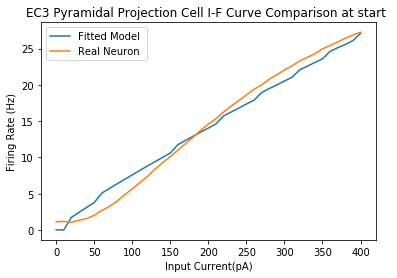

In [9]:


for i in range(0,41):
    test = EC3_spikes.spike_trains()
    if len(test[i]) > 1:
        EC3_freq[i] = 1/(test[i][len(test[i])-1] - test[i][len(test[i])-2])
    else:
        pass   


pylab.plot(np.arange(0,410, 10) ,EC3_freq,label= 'Fitted Model ' )
pylab.plot(np.arange(0,410, 10), EC3_I_f_data[:],label= 'Real Neuron ')
pylab.title('EC3 Pyramidal Projection Cell I-F Curve Comparison at start ')
pylab.xlabel('Input Current(pA)')
pylab.ylabel('Firing Rate (Hz)')
pylab.legend(loc=2)
pylab.show()

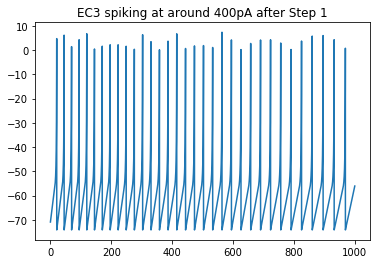

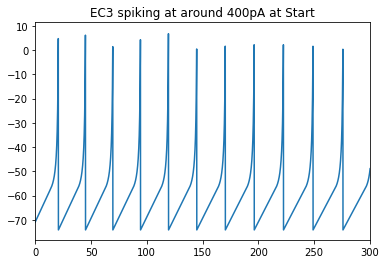

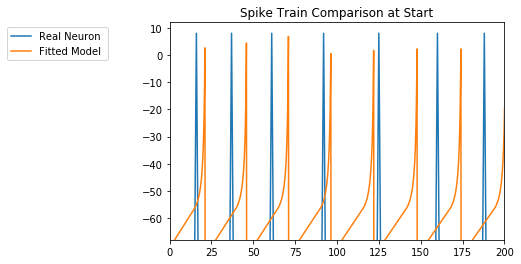

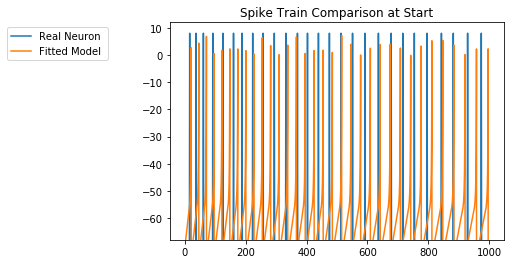

In [10]:
# pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.title('EC3 spiking at around 400pA after Step 1')
pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.show()
pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.title('EC3 spiking at around 400pA at Start')
pylab.xlim(0,300)
pylab.ylim()
pylab.show()
pylab.plot(real_spike_train*1000, label= 'Real Neuron ')
pylab.plot(EC3_state.t/ms,EC3_state.v[39]*1000, label= 'Fitted Model ')
pylab.title('Spike Train Comparison at Start')
pylab.xlim(0,200)
pylab.ylim(-68,12)
#pylab.legend(loc=10)
pylab.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
pylab.show()
pylab.title('Spike Train Comparison at Start')
pylab.plot(real_spike_train*1000, label= 'Real Neuron ')
pylab.plot(EC3_state.t/ms,EC3_state.v[39]*1000, label= 'Fitted Model ')
pylab.ylim(-68,12)
#pylab.legend(loc=10)
pylab.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
pylab.show()


## Step 1. Vary a and d, holding b and k_low constant
* We are going to use the best value of k_high from the previous step

### Define function for step 1

* Computing parameters based on steady sate frequency, the last ISI

In [11]:
%%px --local

# use k_high from previous step

# this creates an iterable list for a and d, replacement for nested for looop
a_list = np.arange(.000001,.00001, .000001)
d_list = np.arange(0,4,.1)  # 6 is the most adaptation I would want
a,d = zip(*itertools.product(a_list,d_list)) 

final_period = (EC3_spike_times[len(EC3_spike_times)-1] - EC3_spike_times[len(EC3_spike_times)-2])*ms 
final_ISI = (1/final_period)


def step_1(a,d):
    global EC3_I_f_data
    global k_high
    
    EC3_input = np.arange(0,410, 10) 
    EC3_input = np.broadcast_to(EC3_input, (1000,41))
    EC3_input = TimedArray(EC3_input*pamp, dt=1*ms )
    
    # EC3 pyramidal neuron parameters.  
    EC3_a = a/ms
    EC3_b = 5 * nsiemens
    EC3_c = -74.153 *mV
    EC3_d = d *pA #I think I shoudl use pico amps for this.. seriously 
    EC3_v_peak = 7.7 * mV # this is v_peak. There is no such thing as a firing threshold. 
    EC3_v_r = -70.9 # mV
    EC3_v_t = -56.9 # mV 
    EC3_C = C * pF
    EC3_k_low = .097 * nsiemens/mV
    EC3_k_high = k_high * nsiemens/mV
    
    #the quadratic terms based on v_r and v_t
    EC3_v_a = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
    EC3_v_b = -1*(EC3_v_r + EC3_v_t) /ms#/ms
    EC3_v_c = (EC3_v_r * EC3_v_t) *(mV/ms)#*mV/ms 
    # Standard Izhikevich neuron equations.  
    EC3_p_eqs = '''
    dv/dt = ((k*(mV/nS)*(EC3_v_a*(v**2) + EC3_v_b*(v) + EC3_v_c))*pF/EC3_C - u/EC3_C + I/EC3_C ) : volt
    du/dt = EC3_a*((EC3_b*(v - EC3_v_r *mV) - u)) : amp
    I = EC3_input(t,i): amp
    k = (v<(-56.9 * mV))*EC3_k_low+(v>=(-56.9 *mV))*EC3_k_high : siemens/volt
    ''' 

    EC3_post_spike = '''
    v = EC3_c
    u += EC3_d
    '''

    EC3 = NeuronGroup(41, EC3_p_eqs, threshold='v>EC3_v_peak', reset = EC3_post_spike) #threshold in this model is the peak threshold

    EC3_state = StateMonitor(EC3,('v'), record=True)
    EC3_spikes = SpikeMonitor(EC3)
    EC3.v[:] = -70.9 * mV

    run(10*second)
    
    spike_trains = EC3_spikes.spike_trains()

    
    test = spike_trains[39]
    EC3_freq = 1/(test[len(test)-1] - test[len(test)-2])
    
    return (EC3_freq-final_ISI)**2
    

### Execute step 1

In [12]:
step_1_output = lview.map_async(step_1, a, d )
print step_1_output.wait_interactive()
step_1_err =  np.asarray(step_1_output.get()) # reshape step 1 output to matrix, so we can plot
step_1_err = np.reshape(step_1_err, (len(a_list),len(d_list)))

#np.savez('/scratch/sanjay/modeling/EC3_fitting_3', k_high_err = k_high_err, step_1_err = step_1_err)

 360/360 tasks finished after  576 s
done
None



#t = np.asarray(np.unravel_index(out.argmin(), out.shape))


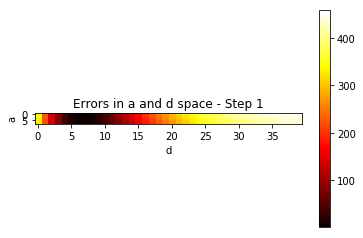

In [13]:
pylab.imshow(step_1_err,cmap='hot', interpolation='nearest', norm= autoscale(), aspect=1 )#cmap='hot', 
pylab.colorbar()
pylab.title('Errors in a and d space - Step 1')
pylab.xlabel('d')
pylab.ylabel('a')
pylab.show()

### check for the best values of a and d

In [14]:
np.argmin(step_1_err) # check all a and d values

327

In [15]:
#tep_1_err_valid = step_1_err[1:100,0:20] # a values of 0 are meaningless, meaning there is no adaptation. We don't want that

In [16]:
# This will tell us what were the best values of a and d

a_d_mins = np.asarray(np.unravel_index(step_1_err.argmin(), step_1_err.shape)) 
print a_d_mins

[8 7]


In [17]:


# use the best a and d
a = (a_d_mins[0])*.000001 + .000001 # .00001 is the step size offset. Because we are excluding 0. See step above
d = a_d_mins[1]*.1 

# need to push data to all clients
dview.push(dict(a=a,d=d))


<AsyncResult: _push>

### Let's re-examine the fit after step 1, with b and k_low still not optimized

In [18]:
EC3_input = np.arange(0,410, 10) 
EC3_input = np.broadcast_to(EC3_input, (1000,41))
EC3_input = TimedArray(EC3_input*pamp, dt=1*ms )
# EC3 pyramidal neuron parameters.  
EC3_a = a/ms #a
EC3_b = 5 * nsiemens
EC3_c = -74.153 *mV
EC3_d = d  *pA #d #I think I shoudl use pico amps for this.. seriously 
EC3_theta_reset = 7.7 * mV # this is v_peak, according to the paper this shoudl be 7.7mV 
EC3_v_r = -70.9 # mV
EC3_v_t = -56.9 # mV 
EC3_C = C * pF #C
EC3_k_low = .097 * nsiemens/mV
EC3_k_high = k_high * nsiemens/mV #

#the quadratic terms based on v_r and v_t
EC3_v_a = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
EC3_v_b = -1*(EC3_v_r + EC3_v_t) /ms#/ms
EC3_v_c = (EC3_v_r * EC3_v_t) *(mV/ms)#*mV/ms 
# Standard Izhikevich neuron equations.  
EC3_p_eqs = '''
dv/dt = ((k*(mV/nS)*(EC3_v_a*(v**2) + EC3_v_b*(v) + EC3_v_c))*pF/EC3_C - u/EC3_C + I/EC3_C ) : volt
du/dt = EC3_a*((EC3_b*(v - EC3_v_r *mV) - u)) : amp
I = EC3_input(t,i): amp
k = (v<(-56.9 * mV))*EC3_k_low+(v>=(-56.9 *mV))*EC3_k_high : siemens/volt
''' 


EC3_post_spike = '''
v = EC3_c
u += EC3_d
'''

EC3 = NeuronGroup(41, EC3_p_eqs, threshold='v>EC3_theta_reset', reset = EC3_post_spike) #threshold in this model is the peak threshold

EC3_state = StateMonitor(EC3,('v'), record=True)
EC3_spikes = SpikeMonitor(EC3)
EC3.v[:] = -70.9 * mV

run(1000*ms)

spike_trains = EC3_spikes.spike_trains()

test = spike_trains[39]
EC3_freq = 1/(test[len(test)-1] - test[len(test)-2])

print 'I-f curve error is {}' .format(np.sum((EC3_spikes.count[:]-EC3_I_f_data[:])**2))
print 'Spike train error is {}' .format((EC3_freq-final_ISI)**2)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
WARNING    "i" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 40. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


I-f curve error is 453663.048344
Spike train error is [ 263.71539192] Hz^2


ValueError: x and y must have same first dimension, but have shapes (41,) and (1,)

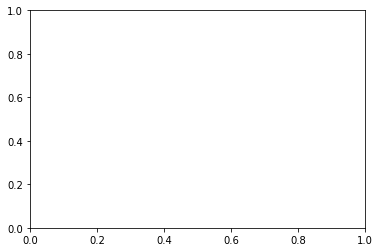

In [19]:
EC3_frequencies = np.zeros(41)

for i in range(0,41):
    test_1 = EC3_spikes.spike_trains()
    if len(test_1[i]) > 1:
        EC3_frequencies[i] = 1/(test_1[i][len(test_1[i])-1] - test_1[i][len(test_1[i])-2])
    else:
        pass   


pylab.plot(np.arange(0,410, 10) ,EC3_frequencies,label= 'Fitted Model ' )
pylab.plot(np.arange(0,410, 10), EC3_I_f_data[:],label= 'Real Neuron ')
pylab.title('EC3 Pyramidal Projection Cell I-F Curve Comparison after step 1 ')
pylab.xlabel('Input Current(pA)')
pylab.ylabel('Firing Rate (Hz)')
pylab.legend(loc=2)
pylab.show()

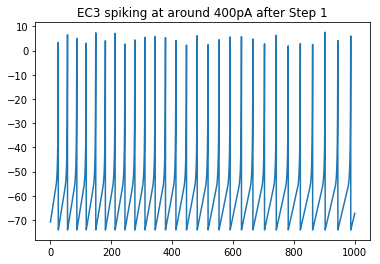

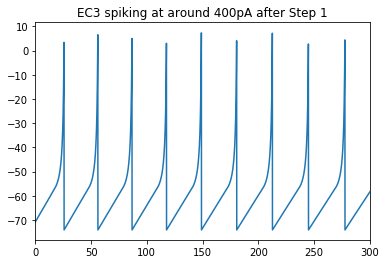

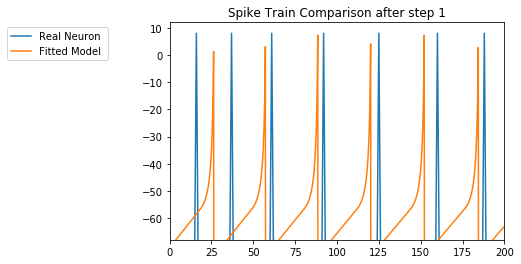

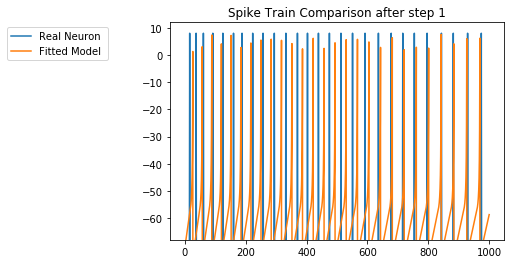

In [19]:
# pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.title('EC3 spiking at around 400pA after Step 1')
pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.show()
pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.title('EC3 spiking at around 400pA after Step 1')
pylab.xlim(0,300)
pylab.ylim()
pylab.show()
pylab.plot(real_spike_train*1000, label= 'Real Neuron ')
pylab.plot(EC3_state.t/ms,EC3_state.v[39]*1000, label= 'Fitted Model ')
pylab.title('Spike Train Comparison after step 1')
pylab.xlim(0,200)
pylab.ylim(-68,12)
#pylab.legend(loc=10)
pylab.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
pylab.show()
pylab.title('Spike Train Comparison after step 1')
pylab.plot(real_spike_train*1000, label= 'Real Neuron ')
pylab.plot(EC3_state.t/ms,EC3_state.v[39]*1000, label= 'Fitted Model ')
pylab.ylim(-68,12)
#pylab.legend(loc=10)
pylab.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
pylab.show()


## Step 2. Change b and k_low, holding a and d constant

In [20]:
%%px --local

a #= .01
d #= 19
k_high = 8
b_list = np.arange(1,5.5,.5)
k_list = np.arange(.1,1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 


def step_2(b,k_low):

    EC3_input = np.arange(0,410, 10) 
    EC3_input = np.broadcast_to(EC3_input, (1000,41))
    EC3_input = TimedArray(EC3_input*pamp, dt=1*ms )
    global d
    global a
    global k_high
    global EC3_I_f_data
    
    # EC3 pyramidal neuron parameters.  
    EC3_a = a/ms
    EC3_b = b * nsiemens
    EC3_c = -74.153 *mV
    EC3_d = d  *pA #I think I shoudl use pico amps for this.. seriously 
    EC3_theta_reset = 7.7 * mV # this is v_peak. There is no such thing as a firing threshold. 
    EC3_v_r = -70.9 # mV
    EC3_v_t = -56.9 # mV 
    EC3_C = C * pF
    EC3_k_low = k_low * nsiemens/mV
    EC3_k_high = k_high * nsiemens/mV

    #the quadratic terms based on v_r and v_t
    EC3_v_a = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
    EC3_v_b = -1*(EC3_v_r + EC3_v_t) /ms#/ms
    EC3_v_c = (EC3_v_r * EC3_v_t) *(mV/ms)#*mV/ms 
    # Standard Izhikevich neuron equations.  
    EC3_p_eqs = '''
    dv/dt = ((k*(mV/nS)*(EC3_v_a*(v**2) + EC3_v_b*(v) + EC3_v_c))*pF/EC3_C - u/EC3_C + I/EC3_C ) : volt
    du/dt = EC3_a*((EC3_b*(v - EC3_v_r *mV) - u)) : amp
    I = EC3_input(t,i): amp
    k = (v<(-56.9 * mV))*EC3_k_low+(v>=(-56.9 *mV))*EC3_k_high : siemens/volt
    ''' 

    EC3_post_spike = '''
    v = EC3_c
    u += EC3_d
    '''

    EC3 = NeuronGroup(41, EC3_p_eqs, threshold='v>EC3_theta_reset', reset = EC3_post_spike) #threshold in this model is the peak threshold

    EC3_state = StateMonitor(EC3,('v'), record=True)
    EC3_spikes = SpikeMonitor(EC3)
    EC3.v[:] = -70.9 * mV

    run(10*second)

    spike_trains = EC3_spikes.spike_trains()
    

    
    test = spike_trains[39]
    EC3_freq = 1/(test[len(test)-1] - test[len(test)-2])
    

    return (EC3_freq-final_ISI)**2
    

    

### Execute step 2

In [21]:
step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_err =  np.asarray(step_2_output.get())
step_2_err = np.reshape(step_2_err, (len(b_list),len(k_list)))
#step_2_err_valid = step_2_err[:, 1:(len(k_list)-1)]

 891/891 tasks finished after  183 s
done
None


In [22]:
#calculate best b and k_low values
b_k_mins = np.asarray(np.unravel_index(step_2_err.argmin(), step_2_err.shape))

b = (b_k_mins[0])*.5 + 1 # .01 is the step size offset. Because we are excluding 0. See step above
k_low = b_k_mins[1]*.1 + .1

%%px --local
b_list = np.arange(.1,10.1,.1)
k_list = np.arange(3.1,6.1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 

step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_1_err =  np.asarray(step_2_output.get()) # goes from all b and k_low: 8.1 to 10
step_2_1_err = np.reshape(step_2_1_err, (len(b_list),len(k_list)))
#step_2_err_valid = step_2_err[:, 1:(len(k_list)-1)]

In [23]:
## The following few cells are extra stuff for exploring the k_low dimension further. Not interested, we'll see about it. 

%%px --local
b_list = np.arange(.1,10.1,.1)
k_list = np.arange(6.1,9.1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 

step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_2_err =  np.asarray(step_2_output.get()) # goes from all b and k_low: 8.1 to 10
step_2_2_err = np.reshape(step_2_2_err, (len(b_list),len(k_list)))

%%px --local
b_list = np.arange(.1,10.1,.1)
k_list = np.arange(9.1,12.1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 

step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_3_err =  np.asarray(step_2_output.get()) # goes from all b and k_low: 8.1 to 10
step_2_3_err = np.reshape(step_2_3_err, (len(b_list),len(k_list)))

%%px --local
b_list = np.arange(.1,10.1,.1)
k_list = np.arange(12.1,15.1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 

step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_4_err =  np.asarray(step_2_output.get()) # goes from all b and k_low: 8.1 to 10
step_2_4_err = np.reshape(step_2_4_err, (len(b_list),len(k_list)))

%%px --local
b_list = np.arange(.1,10.1,.1)
k_list = np.arange(15.1,18.1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 

step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_5_err =  np.asarray(step_2_output.get()) # goes from all b and k_low: 8.1 to 10
step_2_5_err = np.reshape(step_2_5_err, (len(b_list),len(k_list)))

%%px --local
b_list = np.arange(.1,10.1,.1)
k_list = np.arange(18.1,20.1, .1)

b,k_low = zip(*itertools.product(b_list,k_list)) 

step_2_output = lview.map_async(step_2, b, k_low )
print step_2_output.wait_interactive()
step_2_6_err =  np.asarray(step_2_output.get()) # goes from all b and k_low: 8.1 to 10
step_2_6_err = np.reshape(step_2_6_err, (len(b_list),len(k_list)))
np.savez('/scratch/sanjay/modeling/EC3_fitting_2_1',step_2_2_err = step_2_2_err, step_2_1_err = step_2_1_err, step_2_0_err = step_2_0_err,step_2_6_err = step_2_6_err, step_2_5_err = step_2_5_err, step_2_4_err = step_2_4_err, step_2_3_err = step_2_3_err) # k_high_err=k_high_err, step_1_err=step_1_err, 

np.savez('/scratch/sanjay/modeling/EC3_fitting_3', k_high_err = k_high_err, step_1_err = step_1_err, step_2_1_err = step_2_1_err, step_2_0_err = step_2_0_err) #step_2_6_err = step_2_6_err, step_2_5_err = step_2_5_err, step_2_4_err = step_2_4_err, step_2_3_err = step_2_3_err)

step_2_err = np.hstack((step_2_0_err,step_2_1_err))#,step_2_2_err)#,step_2_3_err,step_2_4_err,step_2_5_err,step_2_6_err))
#, step_2_2_err = step_2_2_err)
np.savez('/scratch/sanjay/modeling/EC3_fitting_3_all', step_2_err=step_2_err, k_high_err = k_high_err, step_1_err = step_1_err, step_2_1_err = step_2_1_err, step_2_0_err = step_2_0_err)

#calculate best b and k_low values
b_k_mins = np.asarray(np.unravel_index(step_2_err.argmin(), step_2_err.shape))

b = (b_k_mins[0])/10 + .1 # .01 is the step size offset. Because we are excluding 0. See step above
k_low = b_k_mins[1]/10 + .1

### Check results

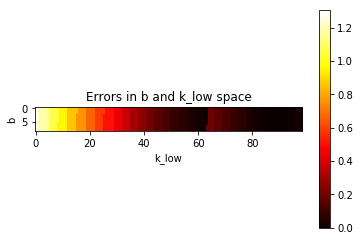

In [24]:
pylab.imshow(step_2_err,cmap='hot',  interpolation='nearest', norm= autoscale()) #aspect=.18 )#cmap='hot',
pylab.colorbar()
pylab.title('Errors in b and k_low space')
pylab.xlabel('k_low')
pylab.ylabel('b')
pylab.show()

## These are the optimized values: 

In [25]:

print  'a is {}' .format(a)
print  'b is {}' .format(b)
print  'd is {}' .format(d)
print  'k_low is {}' .format(k_low)
print  'k_high is {}' .format(k_high)
print 'c is {}' .format(C)

a is 1e-06
b is 1.0
d is 5
k_low is 0.9
k_high is 8
c is 500


In [26]:
EC3_input = np.arange(0,410, 10) 
EC3_input = np.broadcast_to(EC3_input, (1000,41))
EC3_input = TimedArray(EC3_input*pamp, dt=1*ms )


EC3_a = a/ms
EC3_b =b * nsiemens
EC3_c = -74.153 *mV
EC3_d = d  *pA #I think I shoudl use pico amps for this.. seriously 
EC3_theta_reset = 7.7 * mV # this is v_peak. There is no such thing as a firing threshold. 
EC3_v_r = -70.9 # mV
EC3_v_t = -56.9 # mV 
EC3_C = C * pF
EC3_k_low = k_low * nsiemens/mV
EC3_k_high = k_high * nsiemens/mV

#the quadratic terms based on v_r and v_t
EC3_v_a = 1   /(ms*mV)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  #/(ms*mV)
EC3_v_b = -1*(EC3_v_r + EC3_v_t) /ms#/ms
EC3_v_c = (EC3_v_r * EC3_v_t) *(mV/ms)#*mV/ms 
# Standard Izhikevich neuron equations.  
EC3_p_eqs = '''
dv/dt = ((k*(mV/nS)*(EC3_v_a*(v**2) + EC3_v_b*(v) + EC3_v_c))*pF/EC3_C - u/EC3_C + I/EC3_C ) : volt
du/dt = EC3_a*((EC3_b*(v - EC3_v_r *mV) - u)) : amp
I = EC3_input(t,i): amp
k = (v<(-56.9 * mV))*EC3_k_low+(v>=(-56.9 *mV))*EC3_k_high : siemens/volt
''' 

EC3_post_spike = '''
v = EC3_c
u += EC3_d
'''

EC3 = NeuronGroup(41, EC3_p_eqs, threshold='v>EC3_theta_reset', reset = EC3_post_spike) #threshold in this model is the peak threshold

EC3_state = StateMonitor(EC3,('v'), record=True)
EC3_spikes = SpikeMonitor(EC3)

run(1000*ms)

spike_trains = EC3_spikes.spike_trains()

test = spike_trains[39]
EC3_freq = 1/(test[len(test)-1] - test[len(test)-2])


print 'The I-f error after one round of optimization is {}' .format(np.sum((EC3_spikes.count[:]-EC3_I_f_data[:])**2))
print 'Spike train error is {}' .format((EC3_freq-final_ISI)**2)

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


The I-f error after one round of optimization is 250808.992478
Spike train error is [ 0.15066903] Hz^2


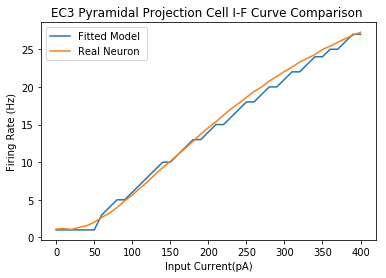

In [27]:
EC3_frequencies = np.zeros(41)

for i in range(0,41):
    test_1 = EC3_spikes.spike_trains()
    if len(test_1[i]) > 1:
        EC3_frequencies[i] = 1/(test_1[i][len(test_1[i])-1] - test_1[i][len(test_1[i])-2])
    else:
        pass   




pylab.plot(np.arange(0,410, 10) ,EC3_freq,label= 'Fitted Model ' )
pylab.plot(np.arange(0,410, 10), EC3_I_f_data[:],label= 'Real Neuron ')
pylab.title('EC3 Pyramidal Projection Cell I-F Curve Comparison ')
pylab.xlabel('Input Current(pA)')
pylab.ylabel('Firing Rate (Hz)')
pylab.legend(loc=2)
pylab.show()

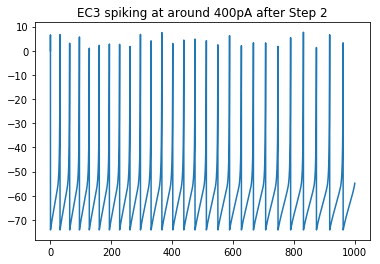

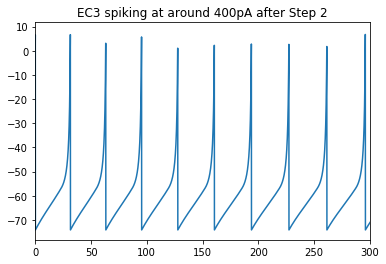

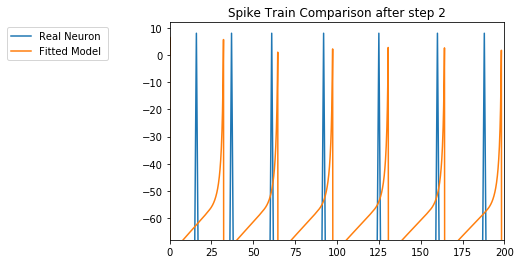

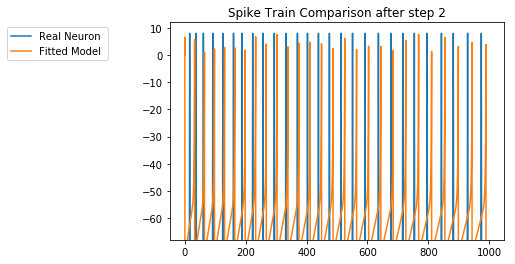

In [28]:
pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.title('EC3 spiking at around 400pA after Step 2')
pylab.show()
pylab.plot(EC3_state.t/ms,EC3_state.v[40]*1000)
pylab.title('EC3 spiking at around 400pA after Step 2')
pylab.xlim(0,300)
pylab.ylim()
pylab.show()
pylab.plot(real_spike_train*1000, label= 'Real Neuron ')
pylab.plot(EC3_state.t/ms,EC3_state.v[39]*1000, label= 'Fitted Model ')
pylab.title('Spike Train Comparison after step 2')
pylab.xlim(0,200)
pylab.ylim(-68,12)
#pylab.legend(loc=10)
pylab.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
pylab.show()
pylab.title('Spike Train Comparison after step 2')
pylab.plot(real_spike_train*1000, label= 'Real Neuron ')
pylab.plot(EC3_state.t/ms,EC3_state.v[39]*1000, label= 'Fitted Model ')
pylab.ylim(-68,12)
#pylab.legend(loc=10)
pylab.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
pylab.show()


## save all data

In [29]:
np.savez('/scratch/sanjay/modeling/EC3_fitting_8',step_2_err = step_2_err, step_1_err = step_1_err)#, step_0_err=step_0_err) # k_high_err=k_high_err, step_1_err=step_1_err, 

In [30]:
# Further analysis

from brian2 import * 
#import brian2 as bn
import numpy as np
import pylab
import itertools
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from __future__ import division
%matplotlib inline

data = np.load('EC3_fitting_7.npz')

step_1=data['step_1_err']
step_1

# this is the I-f data for EC3 pyramidal neuron
s = pd.read_csv('EC3_I_f.csv',header = None)
EC3_I_f_data = s.as_matrix(columns=[1])

## Let's compare this with actual neuron, a type 1 projection (pyramidal) cell from Medial Entorhinal Cortex.
### This cell is known to project to CA1 and subiculum.

* Spiking behavior at ~400pA

![EC3_type1](EC3_type1_firing.png)